# Rydberg calculations for $^{87}$Rb
References:
 * Minho's Thesis
 * Paul Huillery Thesis
 * Rydberg_atoms_a_primer_notebook (Pair Interaction)

In [60]:
from physconsts import *
from rbconsts import *
from numpy import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan

from arc import *
from scipy.special import sph_harm as ylm

# other
mpl.rcParams.update(mpl.rcParamsDefault)

In [13]:
# various setup
qq = ee**2/(4*pi*e0)

ldict = {0:'S',1:'P',2:'D',3:'F'} 
jdict = {.5:'1/2',1.5:'3/2',2.5:'5/2',3.5:'7/2'}

LeRoy Radius
$R_{LR} = 2 \left( \sqrt{\langle r_1^2 \rangle} + \sqrt{\langle r_2^2 \rangle} \right) \approx 4 n^2 a_0 $

In [14]:
# Assumption of well-separated Rydberg atoms: atoms are separated by
# the LeRoy radius 

Rlr = lambda n,l: a0*sqrt(8*n**2*(5*n**2 + 1 - 3*l*(l+1)))

Rlr(87,2)

2.5326318795200154e-06

In [5]:
# Calculate oscillator strength between |87d_5/2> and nearby 
# states |n'l'J'> states. then calculate energy shifts from 
# forster resonances in pair states using only those states
# with some threshold level of oscillator strength



In [15]:
rb = Rubidium(87)

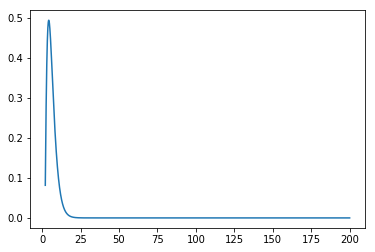

In [8]:
# TODO: try to make contour plots of the whole |psi|^2, i.e. including
# the angular part
s = 0.5
l = 0
j = 0.5
n = 5

rmin = rb.alphaC**(1/3)
rmax = 2*n*(n+15)

rpts, radial = rb.radialWavefunction(
    l,s,j,
    rb.getEnergy(n,l,j)/27.211, # don't know why 27.211 
    rmin,
    rmax,
    step=0.001
)

plt.plot(rpts, radial) 

In [9]:
## dipole matrix elements

n1 = 87
s = 0.5
l1 = 2
j1 = 2.5
mj1 = 2.5 # stretched state
q = -1 # lin-pol light

n2list = range(84,88)

ticklabels = []
matelems = []

for n2 in n2list:
    for l2 in [l1-1, l1+1]:
        for j2 in arange(l2-s,l2+s+1,1):
            if mj1 + q <= j2: 
                mj2 = mj1 + q
                matelems.append(
                    abs(rb.getDipoleMatrixElement(n1,l1,j1,mj1,n2,l2,j2,mj2,q))
                )
                ticklabels.append(f'|{n2}{ldict[l2]}_{jdict[j2]},{jdict[mj2]}>')

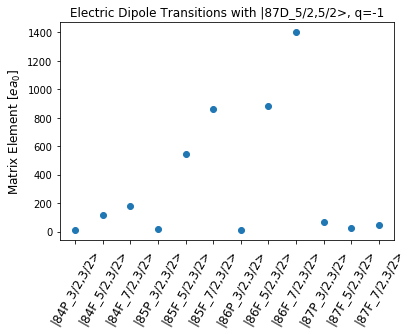

In [10]:
fig,ax = plt.subplots()

ax.scatter(range(len(matelems)),matelems)
ax.set_xticks(range(len(matelems)))
ax.set_xticklabels(ticklabels, rotation=60, fontsize='large')
ax.set_ylabel(r'Matrix Element [$e a_0$]', fontsize='large')
ax.set_title(f'Electric Dipole Transitions with |{n1}{ldict[l1]}_{jdict[j1]},{jdict[mj1]}>, q={q}')
plt.show()

In [17]:
def V_dd(a1,b1,a2,b2,r12,atom):
    """
    dipole-dipole matrix elem including fine structure
    a1,b1,a2,b2 are each lists of form [n,l,j,mj] denoting the states 1 and 2 of atoms a,b
    r12 is atom separation
    atom is a PairInteraction atom object
    """
    na1,la1,ja1,ma1 = a1
    nb1,lb1,jb1,mb1 = b1
    na2,la2,ja2,ma2 = a2
    nb2,lb2,jb2,mb2 = b2
    
    q=0 # dipole has linear polarization
    matelem = 0

    for p in [-1,0,1]:
        try:
            matelem += clebsch_gordan(1,1,2,p,-p,q)* \
                atom.getDipoleMatrixElement(na1,la1,ja1,ma1,na2,la2,ja2,ma2,p)* \
                atom.getDipoleMatrixElement(nb1,lb1,jb1,mb1,nb2,lb2,jb2,mb2,-p)
        except ValueError:
            pass # CG coefficient is zero; ignore.
    
    matelem *= -qq**2*sqrt(6)/r12
    return matelem

In [101]:
# initial pair state, ignoring Zeeman substates
na1 = 43
la1 = 2
ja1 = 5/2

nb1 = 43
lb1 = 2
jb1 = 5/2
# final pair state, """
na2 = 45
la2 = 1
ja2 = 3/2

nb2 = 41
lb2 = 3
jb2 = 7/2 # makes the most sense 

delta = -(rb.getEnergy(na1,la1,ja1) 
         + rb.getEnergy(nb1,lb1,jb1)
         - rb.getEnergy(na2,la2,ja2)
         - rb.getEnergy(nb2,lb2,jb2))*ee/(2*pi*hbar*10**6)
print(f"Forster defect = {delta} [MHz]")

# initial state with possible projections
basis_i = [[[na1, la1, ja1, ma],[nb1, lb1, jb1, mb]] for ma in arange(-ja1, ja1+1,1) for mb in arange(-jb1, jb1+1,1)]
# final state with possible projections
basis_f = [[[na2, la2, ja2, ma],[nb2, lb2, jb2, mb]] for ma in arange(-ja2, ja2+1,1) for mb in arange(-jb2, jb2+1,1)]

basis = basis_i + basis_f
dim = len(basis)
print(f"number of basis pair states: {dim}")

Forster defect = -8.334369904025891 [MHz]
number of basis pair states: 68


In [100]:
basis[]

[[[43, 2, 2.5, -2.5], [43, 2, 2.5, -2.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, -1.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, -0.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, 0.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, 1.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, 2.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, -2.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, -1.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, -0.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, 0.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, 1.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, 2.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, -2.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, -1.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, -0.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, 0.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, 1.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, 2.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, -2.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, -1.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, -0.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, 0.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, 1.5]],
 [[43, 2, 2.5, 0.5], [43, 2

In [108]:
# build the hamiltonian

H_atom = zeros((dim,dim))
for i in range(dim - int((2*ja2+1)*(2*jb2+1)),dim):
    H_atom[i,i] = delta
    
H_vdd = zeros((dim,dim))
for i,pairstate_i in enumerate(basis):
    for j,pairstate_j in enumerate(basis):
        state_ai,state_bi = pairstate_i
        state_aj,state_bj = pairstate_j
        vdd_elem = v_dd(state_ai,state_bi,state_aj,state_bj,1,rb)
        
        

-8.334369904025891

In [92]:
basis = [[[na1, la1, ja1, ma],[nb1, lb1, jb1, mb]] for ma in arange(-ja1, ja1+1,1) for mb in arange(-jb1, jb1+1,1)]
basis

[[[43, 2, 2.5, -2.5], [43, 2, 2.5, -2.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, -1.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, -0.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, 0.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, 1.5]],
 [[43, 2, 2.5, -2.5], [43, 2, 2.5, 2.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, -2.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, -1.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, -0.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, 0.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, 1.5]],
 [[43, 2, 2.5, -1.5], [43, 2, 2.5, 2.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, -2.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, -1.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, -0.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, 0.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, 1.5]],
 [[43, 2, 2.5, -0.5], [43, 2, 2.5, 2.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, -2.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, -1.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, -0.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, 0.5]],
 [[43, 2, 2.5, 0.5], [43, 2, 2.5, 1.5]],
 [[43, 2, 2.5, 0.5], [43, 2

In [ ]:
const

In [29]:
log10(ee/(2*pi*hbar)) # this says 1 eV is about 100 THz, so E ~ a few eV has an optical wavelength

14.383454371569494